# Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
TRAIN_PATH = '/Users/annastarostina/Downloads/ml/lab3/train.csv'
TEST_PATH = '/Users/annastarostina/Downloads/ml/lab3/test.csv'

### Инициализация

In [4]:
train_df = pd.read_csv(TRAIN_PATH, index_col=["Date"], parse_dates=["Date"])


In [5]:
train_df.head()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-01-10,1,1453329.50,71.89,2.603,211.671989,7.838
2010-02-04,1,1594968.28,62.27,2.719,210.820450,7.808
2010-02-07,1,1492418.14,80.91,2.669,211.223533,7.787
2010-02-19,1,1611968.17,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,46.63,2.561,211.319643,8.106


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6255 entries, 2010-01-10 to 2012-10-08
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Weekly_Sales  6255 non-null   float64
 2   Temperature   6255 non-null   float64
 3   Fuel_Price    6255 non-null   float64
 4   CPI           6255 non-null   float64
 5   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 342.1 KB


Все признаки не имеют NaN значений

### Анализ

Зависимость признаков между собой

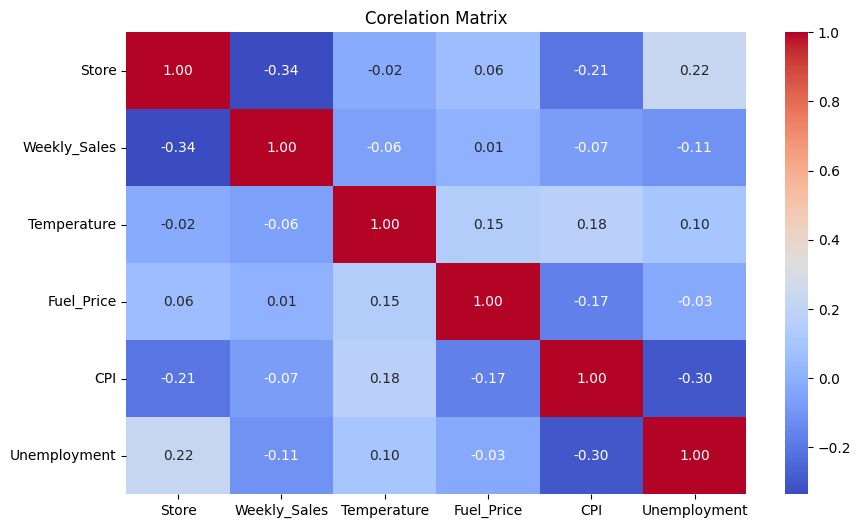

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap( train_df.corr(), annot=True, fmt='.2f',cmap='coolwarm')
plt.title('Corelation Matrix')
plt.show()

Временной ряд со скользящим средним

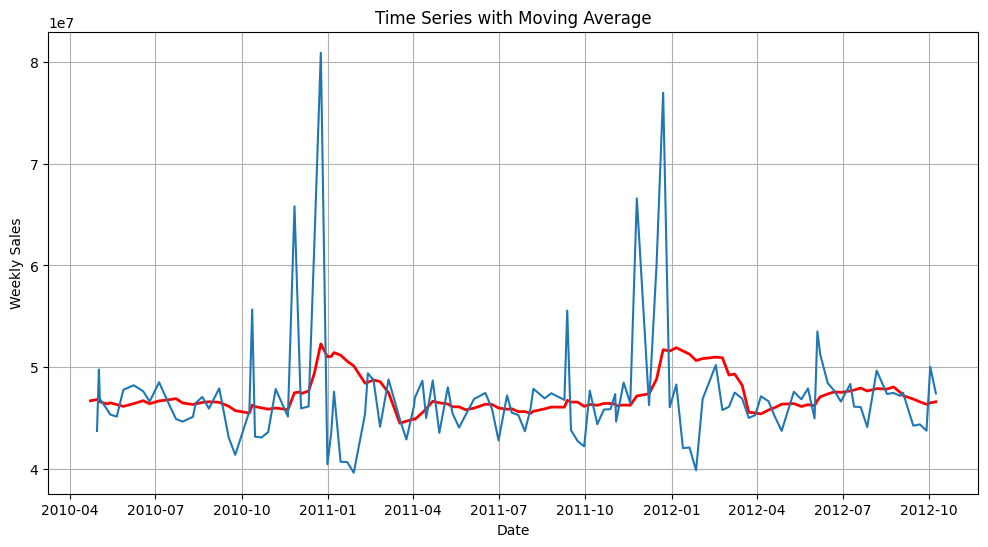

In [8]:
weekly_sales = train_df.groupby('Date')['Weekly_Sales'].sum()
rolling_data = weekly_sales.rolling(window=12).mean()
plt.figure(figsize=(12, 6))
plt.plot(rolling_data, color='red', linewidth=2)
plt.plot(weekly_sales[12:])
plt.title('Time Series with Moving Average')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Выводы:

* Продажи возрастают с конца октября

* Максимальные продажи в конце года

* Присутствуют резкие спады продаж в начале каждого года

* Скользящее среднее имеет небольшие подъёмы в начале года => можем говорить о годовой сезонности

Преобразуем дату

In [9]:
def add_time_features(df):
    df['Weekday'] = df.index.weekday 
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    return df

train_df = add_time_features(train_df)


## Линейная регрессия

In [10]:
yTrue = []
yPred = []
models = {} 

for store_id in train_df['Store'].unique():

    store_data = train_df[train_df['Store'] == store_id]
    
    X = store_data.drop("Weekly_Sales", axis=1).drop("Store", axis=1)
    y = store_data['Weekly_Sales']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2
    )

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    models[store_id] = model
    
    y_pred = model.predict(X_test)

    yTrue.extend(y_test)
    yPred.extend(y_pred)

In [11]:
mape = mean_absolute_percentage_error(yTrue, yPred)

print(mape)

0.07470736348401077


# Submit

In [13]:
test_df = pd.read_csv(TEST_PATH, index_col=["Date"], parse_dates=["Date"])
test_df = add_time_features(test_df)

In [14]:
predictions = []

for store_id, store_data in test_df.groupby('Store'):
    model = models.get(store_id)
    X = store_data.drop("Store", axis=1)
    y = model.predict(X)
    predictions.extend(y)

data = {
    "Weekly_Sales": predictions
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")